**import Libraries**


In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input, Dropout,Flatten,Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical


from IPython.display import SVG,Image
import tensorflow as tf
print("Tensorflow version:",tf.__version__)



Tensorflow version: 2.16.1


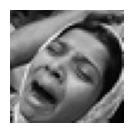

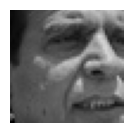

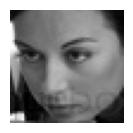

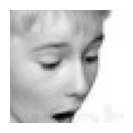

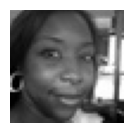

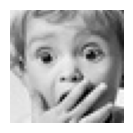

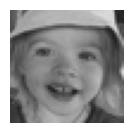

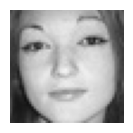

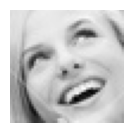

In [2]:
images=glob("train/**/**")
for i in range(9):
    image= random.choice(images)
    plt.figure(figsize=(15,15))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image))
    plt.axis("off")
    

**Preparing Data For Training**

In [3]:
img_size= 48
batch_size=64
datagen_train=ImageDataGenerator()
train_generator=datagen_train.flow_from_directory("train/",target_size=(img_size,img_size),
                                                 color_mode="grayscale",batch_size=batch_size,class_mode="categorical",shuffle=True)

dataden_validation=ImageDataGenerator()
validation_generator=datagen_train.flow_from_directory("test/",target_size=(img_size,img_size),
                                                       color_mode="grayscale",batch_size=batch_size,class_mode="categorical",shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**


In [4]:
def Convolution(input_tensor,filters,kernel_size):
    x=Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    x=Dropout(0.25)(x)
    return x
    

In [5]:
def Dense_f(input_tensor, nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    return x
    

In [6]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1= Convolution(inputs,32,(3,3))
    conv_2= Convolution(inputs,64,(5,5))
    conv_3= Convolution(inputs,128,(3,3))
    
    flatten=Flatten()(conv_3)
    
    dense_1= Dense_f(flatten,256)
    output=Dense(7, activation= "softmax")(dense_1)
    
    model= Model(inputs=[inputs],outputs=[output])
    opt=Adam(learning_rate=0.0005)
    model.compile(loss=['categorical_crossentropy'],optimizer=opt ,metrics=['accuracy'])
    return model
    
    

In [7]:
model=model_fer((48,48,1))
model.summary()
    

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

**Intializing the model**


In [8]:
epochs=15
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps= validation_generator.n//validation_generator.batch_size
checkpoint=ModelCheckpoint("model_weights.weights.h5",monitor='val_accuracy',save_weights_only=True,mode='max',verbose=1)
callbacks=[checkpoint]

**Training The Model**

In [9]:
history=model.fit(
x=train_generator,steps_per_epoch=steps_per_epoch,
epochs=epochs,validation_data=validation_generator,
validation_steps=validation_steps,
callbacks=callbacks
)

Epoch 1/15


C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3242 - loss: 1.8332
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1327s 3s/step - accuracy: 0.3243 - loss: 1.8328 - val_accuracy: 0.3903 - val_loss: 1.5681
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:09:22 9s/step - accuracy: 0.4844 - loss: 1.3431

C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 60s 113ms/step - accuracy: 0.4844 - loss: 1.3431 - val_accuracy: 0.4000 - val_loss: 1.7541
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4843 - loss: 1.3706
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 1054s 2s/step - accuracy: 0.4843 - loss: 1.3706 - val_accuracy: 0.4279 - val_loss: 1.4903
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 8:08 1s/step - accuracy: 0.5000 - loss: 1.3842
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.5000 - loss: 1.3842 - val_accuracy: 0.3000 - val_loss: 1.8779
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5512 - loss: 1.1951
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 742s 2s/step - accuracy: 0.5512 - loss: 1.1951 - val_accuracy: 0.4516 - val_loss: 1.4564
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 6:59 937ms/step - accuracy

**Evaluate the Model**

In [10]:
model.evaluate(validation_generator)


113/113 ━━━━━━━━━━━━━━━━━━━━ 101s 886ms/step - accuracy: 0.4524 - loss: 1.6046


[1.5798375606536865, 0.46154919266700745]

**Plotting Loss**

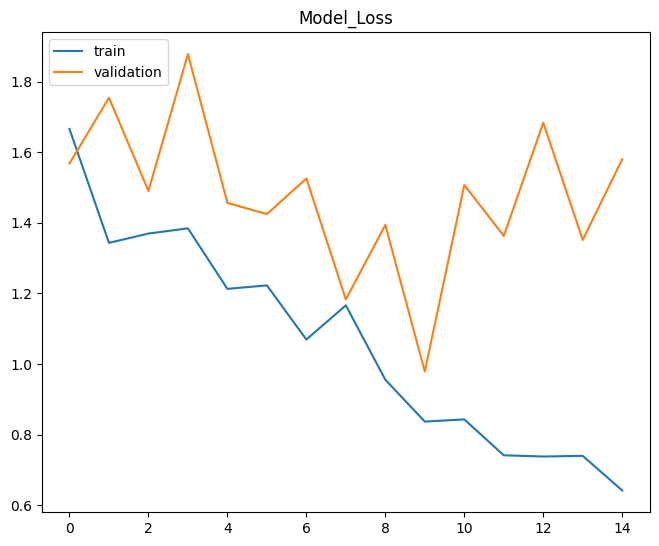

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_Loss')
plt.legend(['train','validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,
                  right=0.95,left=0.0,hspace=0.25,wspace=0.35)
           

**Plotting Accuracy**

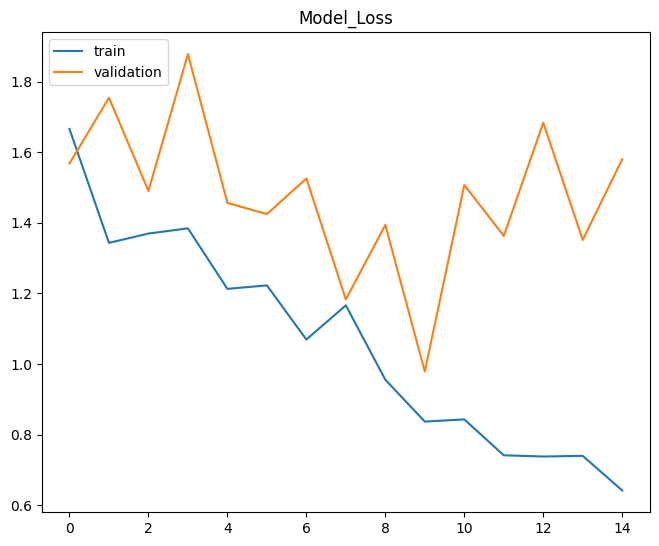

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_Loss')
plt.legend(['train','validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,
                  right=0.95,left=0.0,hspace=0.25,wspace=0.35)
           

**Saving Model**

In [14]:
model_json=model.to_json()
with open("model_a.json","w")as json_file:
    json_file.write(model_json)